In [1]:
# Standard imports
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

Define some helper functions to estimate uncertainties in Rsq values 

In [2]:
from scipy.stats import pearsonr
# Write function to compute bootstrap resampled uncertainties in correlation coefficient.
def my_rsquared(x,y, bootstrap_samples=1000):
    """Returns R^2 and SE thereof based on bootstrap resampling"""
    r2 = pearsonr(x,y)[0]**2 # pingouin.corr(x, y).loc['pearson','r']**2
    N = len(x)
    assert len(x)==len(y), f'len(x)={len(x)} and len(y)={len(y)} are not the same.'
    r2s = np.zeros(bootstrap_samples)
    for i in range(bootstrap_samples):
        ix = np.random.choice(a=N, size=N, replace=True)
        r2s[i] = pearsonr(x[ix],y[ix])[0]**2 
    dr2 = np.std(r2s)
    return r2, dr2


def delta_GF_rsq(x1, x2 ,y, bootstrap_samples=1000):
    """
    Helper function to estimate uncertainty in difference of R^2 value between MAVE-NN and Nishtal
    and Otwinowski and Nisthal. This so that I compute a p-value for a z-test to check whether
    the difference in R^2 values of GB1 folding in statistically significant.
    
    x1 and x2 are arrays for folding energy
    predictions on GB1 from MAVE-NN and Otwinowski
    and y is an array of folding energy measurements from 
    Nisthal
    
    Returns z and sigma for z test
    which may be used to compute a 
    p-value. 

    """
    
    # the quantity I want to compute and 
    # estimate uncertainty in
    Rsq_difference = np.zeros(bootstrap_samples)
    N = len(x1)
    assert N==len(x2)
    assert N==len(y)
    
    for i in range(bootstrap_samples):
        ix = np.random.choice(a=N, size=N, replace=True)
        Rsq_1 = np.corrcoef(x1[ix],y[ix])[0][1]**2
        Rsq_2 = np.corrcoef(x2[ix],y[ix])[0][1]**2
        Rsq_difference[i] = Rsq_1-Rsq_2
    sigma = np.std(Rsq_difference)
    z = np.mean(Rsq_difference)
    zs = Rsq_difference/sigma
    
    return z, sigma, zs

Get folding energy data for GB1

In [3]:
figS5_data = np.load('figS5_data_dict.21.06.26.npz', allow_pickle=True)
delta_GF_mavenn = figS5_data['delta_GF_mavenn']
delta_GF_Otwinowski = figS5_data['delta_GF_Otwinowski']
delta_GF_Nisthal = figS5_data['delta_GF_Nisthal']


Compute R^2 values and uncertainties between MAVE-NN and Otwinowski predictions with measurements from Nisthal

In [4]:
Rsq_mavenn, std_error_Rsq_mavenn = my_rsquared(delta_GF_mavenn,delta_GF_Nisthal)
Rsq_otwinowski, std_error_Rsq_otwin = my_rsquared(delta_GF_Otwinowski,delta_GF_Nisthal)

print(f'R^2 OtwinMAVE-NN. = {Rsq_mavenn} +/- {std_error_Rsq_mavenn}')
print(f'R^2 Otwin. = {Rsq_otwinowski} +/- {std_error_Rsq_otwin}')

R^2 OtwinMAVE-NN. = 0.5476035871782636 +/- 0.04994854538757042
R^2 Otwin. = 0.5165907263286036 +/- 0.05834756079444568


In [5]:
import seaborn as sns
z, sigma, zs = delta_GF_rsq(delta_GF_mavenn,delta_GF_Otwinowski,delta_GF_Nisthal)
#sns.displot(zs)

# Compute p-value
p = 2*norm.cdf(-(z/sigma))
print(f'p-value = {p}')

p-value = 0.5671046778152595


#### Draw figure S5

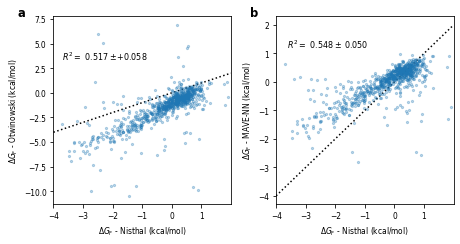

In [6]:
fig, ax = plt.subplots(1,2,figsize=[6.5, 3.5])

fontsize=7.5

xlims = [-4,2]
xticks = [-4,-3,-2,-1,0,1]

ax[0].scatter(delta_GF_Nisthal, delta_GF_Otwinowski,s=5,alpha=0.3, )
ax[0].text(-0.2, 1.0, 'a',fontsize=11.5, fontweight='bold',transform=ax[0].transAxes)
ax[0].text(-3.7,3.3,f'$R^2 = $ {Rsq_otwinowski:.3f} $\pm$+{std_error_Rsq_otwin:.3f}',fontsize=fontsize+0.5)
#ax[0].set_title(f'$R^2 = $ {R_otwinowski**2:.3f}',fontsize=12)
ax[0].set_xlabel('$\Delta G_{\\rm F}$ - Nisthal (kcal/mol)',fontsize=fontsize)
ax[0].set_ylabel('$\Delta G_{\\rm F}$ - Otwinowski (kcal/mol)',fontsize=fontsize)
ax[0].tick_params(labelsize=fontsize)
ax[0].set_xlim(xlims)
ax[0].plot(xlims, xlims, ':k', zorder=-1)
ax[0].set_xticks(xticks)

ax[1].text(-0.15, 1.0, 'b',fontsize=11.5, fontweight='bold',transform=ax[1].transAxes)
ax[1].text(0.06,0.83,f'$R^2 = $ {Rsq_mavenn:.3f} $\pm$ {std_error_Rsq_mavenn:.3f}',fontsize=fontsize+0.5,transform=ax[1].transAxes)
#ax[1].scatter(np.array(mayo_ddG), -(phi_folding-phi_folding_WT+1),s=5,alpha=0.5)
ax[1].scatter(delta_GF_Nisthal, delta_GF_mavenn,s=5,alpha=0.3)
ax[1].set_xlabel('$\Delta G_{\\rm F}$ - Nisthal (kcal/mol)',fontsize=fontsize)
ax[1].set_ylabel('$\Delta G_{\\rm F}$ - MAVE-NN (kcal/mol)',fontsize=fontsize)
ax[1].tick_params(labelsize=fontsize)
ax[1].set_xlim(xlims)
ax[1].plot(xlims, xlims, ':k', zorder=-1)
ax[1].set_xticks(xticks)

fig.tight_layout()
fig.savefig('figS5_M1.png',bbox_inches='tight',dpi=300)